Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

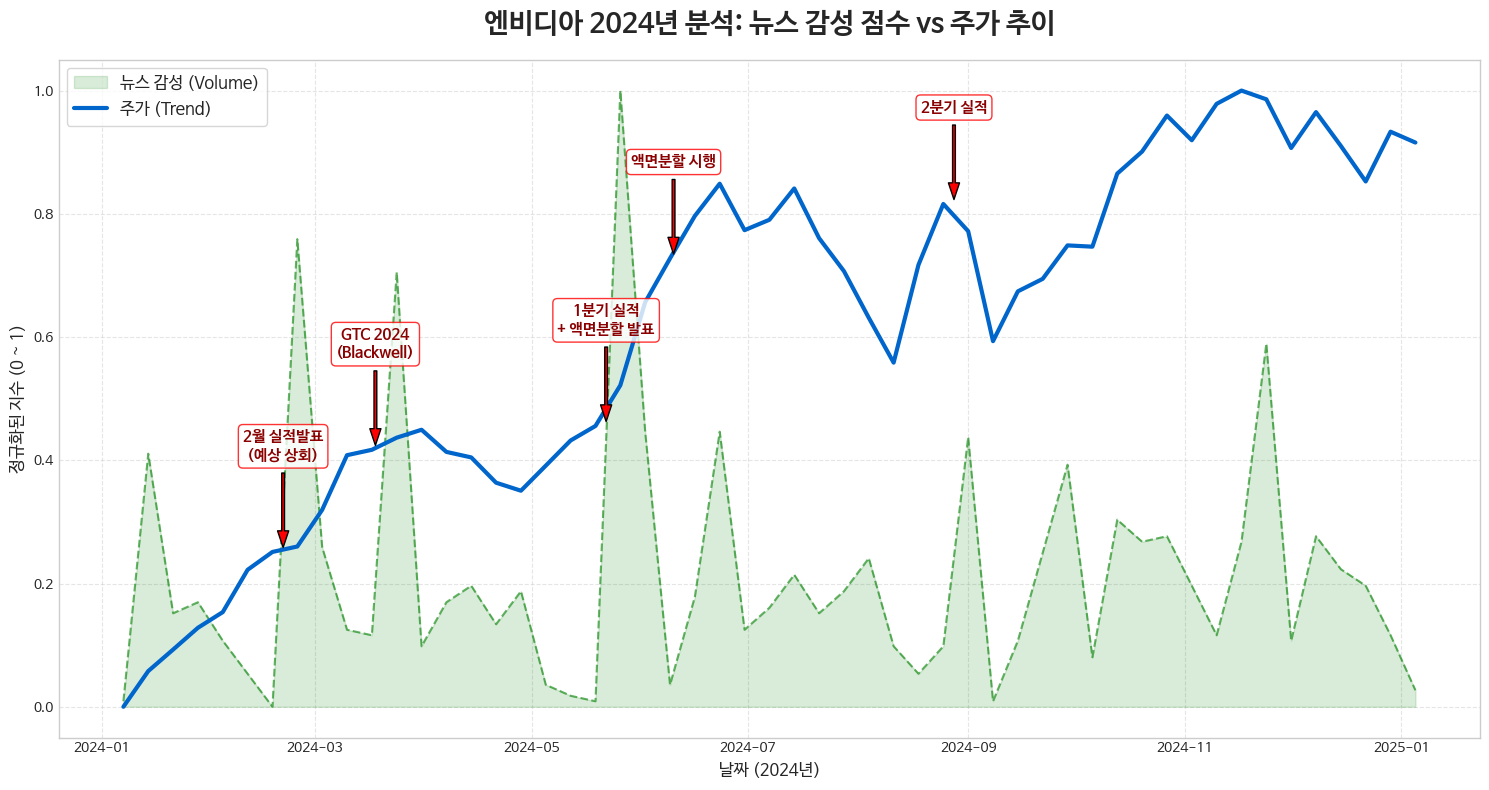


 주간 상관계수는 0.066 입니다.


In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
sys_font = fm.findSystemFonts()

plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False


import pandas as pd
import yfinance as yf
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler


plt.style.use('seaborn-v0_8-whitegrid')
plt.rc('font', family='NanumBarunGothic')

filename = 'nvidia_2024_full_unlimited.csv'

df = pd.read_csv(filename)
df['date'] = pd.to_datetime(df['date'])


positive_keywords = ['surge', 'soar', 'jump', 'rise', 'record', 'high', 'gain', 'bull', 'buy', 'strong', 'growth', 'profit', 'beat', 'revenue', 'up', 'rally', 'success', 'leader', 'dominance', 'boom', 'demand', 'partner', 'breakthrough', 'ai', 'double', 'opportunity', 'top', 'outperform', 'target', 'upgrade', 'split']
negative_keywords = ['drop', 'fall', 'plunge', 'loss', 'miss', 'bear', 'sell', 'down', 'weak', 'low', 'risk', 'concern', 'worry', 'fear', 'crash', 'correction', 'struggle', 'ban', 'restriction', 'bubble', 'volatility', 'slide', 'delay', 'suit', 'insider selling', 'threat', 'competition', 'downgrade']

def get_sentiment_score(text):
    if not isinstance(text, str): return 0
    text = text.lower()
    score = 0
    for word in positive_keywords:
        if word in text: score += 1
    for word in negative_keywords:
        if word in text: score -= 1
    return score

if not df.empty:
    df['sentiment_score'] = df['title'].apply(get_sentiment_score)

    stock = yf.download('NVDA', start='2024-01-01', end='2024-12-31', progress=False, auto_adjust=False)
    stock = stock.reset_index()
    if isinstance(stock.columns, pd.MultiIndex): stock.columns = stock.columns.get_level_values(0)
    stock.columns = [str(c).lower() for c in stock.columns]
    date_col = [c for c in stock.columns if 'date' in c]
    if date_col:
        stock = stock.rename(columns={date_col[0]: 'date'})
        stock['date'] = stock['date'].dt.tz_localize(None)

    news_weekly = df.set_index('date')['sentiment_score'].resample('W').sum()
    stock_weekly = stock.set_index('date')['close'].resample('W').mean()
    weekly_df = pd.concat([news_weekly, stock_weekly], axis=1).dropna()
    weekly_df.columns = ['sentiment_score', 'close']

    # 정규화
    scaler = MinMaxScaler()
    scaled_df = weekly_df.copy()
    scaled_df[['sentiment_score', 'close']] = scaler.fit_transform(scaled_df[['sentiment_score', 'close']])

    # 그래프
    fig, ax1 = plt.subplots(figsize=(15, 8))

    plt.title('엔비디아 2024년 분석: 뉴스 감성 점수 vs 주가 추이', fontsize=20, fontweight='bold', pad=20)

    ax1.fill_between(scaled_df.index, scaled_df['sentiment_score'], color='green', alpha=0.15, label='뉴스 감성 (Volume)')
    ax1.plot(scaled_df.index, scaled_df['sentiment_score'], color='green', linestyle='--', linewidth=1.5, alpha=0.6)

    ax1.plot(scaled_df.index, scaled_df['close'], color='#0066cc', linewidth=3, label='주가 (Trend)')

    # 2024년 엔비디아 주요 이벤트 표시
    events = {
        '2024-02-21': '2월 실적발표\n(예상 상회)',
        '2024-03-18': 'GTC 2024\n(Blackwell)',
        '2024-05-22': '1분기 실적\n+ 액면분할 발표',
        '2024-06-10': '액면분할 시행',
        '2024-08-28': '2분기 실적',
    }

    for date_str, event_name in events.items():
        event_date = pd.to_datetime(date_str)
        if event_date >= scaled_df.index.min() and event_date <= scaled_df.index.max():
            try:
                y_val = scaled_df.loc[scaled_df.index.asof(event_date), 'close']

                ax1.annotate(event_name,
                             xy=(event_date, y_val),
                             xytext=(event_date, y_val + 0.15),
                             arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=8),
                             fontsize=11, fontweight='bold', color='darkred', ha='center',
                             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.8))
            except:
                pass

    ax1.set_ylabel('정규화된 지수 (0 ~ 1)', fontsize=12)
    ax1.set_xlabel('날짜 (2024년)', fontsize=12)
    ax1.legend(loc='upper left', fontsize=12, frameon=True)
    ax1.grid(True, alpha=0.5, linestyle='--')

    plt.tight_layout()
    plt.show()

    corr = weekly_df['sentiment_score'].corr(weekly_df['close'])
    print(f"\n 주간 상관계수는 {corr:.3f} 입니다.")

else:
    print("데이터가 없습니다.")